# tvbl

this is a proof of concept "tvb lite" a browser-based [virtual brain](thevirtualbrain.org) Jupyter
environment.  in the workflow here, we do a simulation, then we try to recover the parameters used. 

In [3]:
%pylab inline
import time, tvbl, mdn, scipy.sparse, ipywidgets as w

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [32]:
import tqdm
import importlib; importlib.reload(tvbl)

<module 'tvbl' from '/home/duke/src/tvbl/content/tvbl.py'>

## interactively choose a simulated ground truth

In [40]:
param_limits = dict(
    a=(1.,1.4,0.01), tau=(1.,2.,0.01), log_k=(-7.,-3.,0.01), log_z=(-1,1,0.01)
)
choices = {'params': None, 'trace': None}

@w.interact(**param_limits)
def run_plot_1(a=0.76, tau=1.0, log_k=-4.02, log_z=-4.0):
    np.random.seed(42)
    
    num_item = 1
    num_node = 90
    num_skip = 1
    dt = 0.1
    sparsity = 0.3
    horizon = 256
    num_time = int(1e2/dt)
    horizonm1 = horizon - 1
    sim_params = np.r_[a, tau, np.exp(log_k)/num_node*80][:,None].astype('f')
    z_scale = np.sqrt(dt)*np.r_[0.01, 0.1].astype('f')*np.exp(log_z)
    choices['params'] = np.r_[a, tau, log_k, log_z]
    
    weights, lengths = np.random.rand(2, num_node, num_node).astype('f')
    lengths[:] *= 0.8
    lengths *= (horizon*dt*0.8)
    zero_mask = weights < (1-sparsity)
    weights[zero_mask] = 0
    csr_weights = scipy.sparse.csr_matrix(weights)
    idelays = (lengths[~zero_mask]/dt).astype('i')+2
    
    y = tvbl.run(
        csr_weights, idelays, sim_params, z_scale, horizon,
        num_item=num_item, num_node=num_node, num_time=num_time,
        dt=dt, num_skip=num_skip, show_time=False,
    )
    choices['trace'] = y
    
    figure(figsize=(8, 2));
    plot(y[:, 0, :, 0], 'k', alpha=0.2);
    grid(1); xlabel('time (ms)'); ylabel('y(t)')

    show()

interactive(children=(FloatSlider(value=1.0, description='a', max=1.4, min=1.0, step=0.01), FloatSlider(value=…

In [7]:
choices['params'], param_limits

(array([ 1.4 ,  1.38, -6.89,  0.79]),
 {'a': (1.0, 1.4, 0.01),
  'tau': (1.0, 2.0, 0.01),
  'log_k': (-7.0, -3.0, 0.01),
  'log_z': (-1, 1, 0.01)})

## features

let's use simple means, variance and average fft

In [41]:
choices['trace'].shape

(1001, 2, 90, 1)

In [83]:
def features(trace):
    x = trace[200:, 0]
    mu = x.mean(axis=0)
    std = x.std(axis=0)
    ft = np.abs(np.fft.fft(x[-256:], axis=0).mean(axis=1))
    return np.concatenate([mu, std, ft]).astype('f')

choices['features'] = features(choices['trace'])
choices['features'].shape

(436, 1)

to know if these are useful, we should sample and look at the distribution of covariance

## sample prior distribution

In [28]:
p_lo, p_hi = np.zeros((2, 4))
for i, key in enumerate('a tau log_k log_z'.split(' ')):
    p_lo[i] = param_limits[key][0]
    p_hi[i] = param_limits[key][1]

def sample_prior(num_item):
    u = np.random.uniform(size=(p_lo.size, num_item)).T
    u *= p_hi - p_lo
    u += p_lo
    return u.T.astype('f')

sample_prior(3)

array([[ 1.018776  ,  1.0533904 ,  1.3950182 ],
       [ 1.0262764 ,  1.1563747 ,  1.6225961 ],
       [-3.8100202 , -6.067204  , -5.2425714 ],
       [ 0.6603572 , -0.02033596,  0.2424286 ]], dtype=float32)

In [103]:
sample_params = []
sample_features = []

for i_batch in tqdm.trange(num_batch := 32):
    num_item = 32
    num_node = 90
    num_skip = 1
    dt = 0.1
    sparsity = 0.3
    horizon = 256
    num_time = int(1e2/dt)
    horizonm1 = horizon - 1
    sim_params = sample_prior(num_item)
    sample_params.append(sim_params.copy())
    sim_params[2] = np.exp(sim_params[2])/num_node*80 # k
    z_scale = np.sqrt(dt)*np.r_[0.01, 0.1].astype('f')[:,None]*np.exp(sim_params[3])
    sim_params = sim_params[:3]  # keep z separate
    
    weights, lengths = np.random.rand(2, num_node, num_node).astype('f')
    lengths[:] *= 0.8
    lengths *= (horizon*dt*0.8)
    zero_mask = weights < (1-sparsity)
    weights[zero_mask] = 0
    csr_weights = scipy.sparse.csr_matrix(weights)
    idelays = (lengths[~zero_mask]/dt).astype('i')+2
    
    y = tvbl.run(
        csr_weights, idelays, sim_params, z_scale, horizon,
        num_item=num_item, num_node=num_node, num_time=num_time,
        dt=dt, num_skip=num_skip, show_time=False
    )

    sample_features.append(features(y))

sample_params = np.array(sample_params).transpose(1, 0, 2).reshape(-1, num_batch*num_item)
sample_features = np.array(sample_features).transpose(1, 0, 2).reshape(-1, num_batch*num_item)

100%|████████████████████████████████████████████████████| 32/32 [00:18<00:00,  1.69it/s]


In [104]:
# TODO put into mdn
ok = np.isfinite(sample_features).all(axis=0)
sample_params = sample_params[:, ok]
sample_features = sample_features[:, ok]
print(f'dropped {(~ok).sum()} non finite samples, leaving {ok.sum()} samples')

dropped 0 non finite samples, leaving 1024 samples


In [106]:
importlib.reload(mdn)

<module 'mdn' from '/home/duke/src/tvbl/content/mdn.py'>

In [114]:
mdn_w, _, mdn_f = mdn.train_mdn(
    sample_params.T,
    sample_features.T,
    K=1, H=(64, ),
    niter=800,
)

Starting training...
Iteration     1/800, Loss: 19.7746
Iteration   100/800, Loss: 2.3582
Iteration   200/800, Loss: 1.1557
Iteration   300/800, Loss: 0.3193
Iteration   400/800, Loss: -0.2016
Iteration   500/800, Loss: -0.5236
Iteration   600/800, Loss: -0.7156
Iteration   700/800, Loss: -0.8356
Iteration   800/800, Loss: -1.0071
Training finished.


In [115]:
post_params = mdn.sample(mdn_w, mdn_f, choices['features'][:,0], 200)

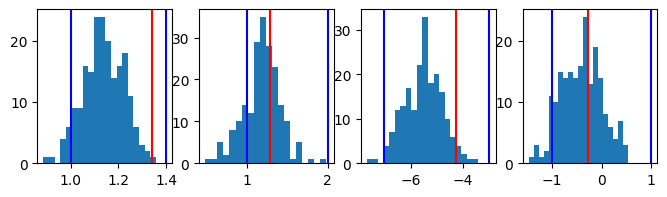

In [116]:
figure(figsize=(8,2))
for i in range(4):
    subplot(1, 4, i+1)
    axvline(choices['params'][i], color='r')
    axvline(p_lo[i], color='b')
    axvline(p_hi[i], color='b')
    hist(post_params[:,i], 20)